In [ ]:
import matplotlib.pyplot as plt
from datasets import load_dataset

dataset = load_dataset("EduardoPacheco/FoodSeg103")
train, validation = dataset["train"], dataset["validation"]

sample = train[0]


# Show the image and its mask
plt.subplot(1, 2, 1)
plt.imshow(sample["image"])
plt.title("Image")

plt.show()

In [25]:
import numpy as np

def extract_ingredients(chosen_images):
    mask = np.array(chosen_images["label"])
    unique_labels = np.unique(mask)
    # we also filter out category 0, since 0 = background
    unique_labels = unique_labels[unique_labels != 0]
    chosen_images["ingredients"] = unique_labels.tolist()
    return chosen_images

train = train.map(extract_ingredients)
validation = validation.map(extract_ingredients)
print(train[0]["ingredients"])
print(validation[0]["ingredients"])


[48, 66, 90]
[20, 56, 66, 84, 96]


In [26]:
num_of_classes = 104

def one_hot_encode(example):
    ingredient_vector = np.zeros(num_of_classes, dtype=np.float32)
    for cls in example["ingredients"]:
        ingredient_vector[int(cls)] = 1.0
    example["ingredient_vector"] = ingredient_vector
    return example

train = train.map(one_hot_encode)
validation = validation.map(one_hot_encode)

In [27]:
import tensorflow as tf

img_size = 224

def preprocess_image(image):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, (img_size, img_size))
    return image

In [28]:
batch_size = 32

train_dataset = train.to_tf_dataset(
    columns="image",
    label_cols="ingredient_vector",
    shuffle=True,
    batch_size=None
)

validation_dataset = validation.to_tf_dataset(
    columns="image",
    label_cols="ingredient_vector",
    shuffle=False,
    batch_size=None
)

train_dataset = train_dataset.map(lambda x, y: (preprocess_image(x), y)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.map(lambda x, y: (preprocess_image(x), y)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [29]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

base_model = MobileNetV2(
    include_top=False,
    input_shape=(img_size, img_size, 3),
    weights="imagenet"
)
base_model.trainable = False  # freeze for transfer learning

inputs = layers.Input(shape=(img_size, img_size, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_of_classes, activation="sigmoid")(x)  # sigmoid = multi-label
model = models.Model(inputs, outputs)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 104)            │       133,224 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,391,208 (9.12 MB)

 Trainable params: 133,224 (520.41 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [30]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [31]:
epochs = 10

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs
)

Epoch 1/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.0197 - loss: 0.3044 - val_accuracy: 0.0445 - val_loss: 0.1500
Epoch 2/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 211s 1s/step - accuracy: 0.0466 - loss: 0.1494 - val_accuracy: 0.0731 - val_loss: 0.1320
Epoch 3/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 268s 1s/step - accuracy: 0.0590 - loss: 0.1367 - val_accuracy: 0.0773 - val_loss: 0.1257
Epoch 4/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 267s 1s/step - accuracy: 0.0714 - loss: 0.1310 - val_accuracy: 0.0885 - val_loss: 0.1216
Epoch 5/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 264s 1s/step - accuracy: 0.0795 - loss: 0.1268 - val_accuracy: 0.0885 - val_loss: 0.1185
Epoch 6/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 259s 1s/step - accuracy: 0.0791 - loss: 0.1234 - val_accuracy: 0.0927 - val_loss: 0.1161
Epoch 7/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 252s 1s/step - accuracy: 0.0901 - loss: 0.1201 - val_accuracy: 0.0984 - val_loss: 0.1139
Epoch 8/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 217s 1s/step - accuracy: 0.0941 - loss: 0.1176 - val_accu

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
True: [20 56 66 84 96]
Predicted: [84]


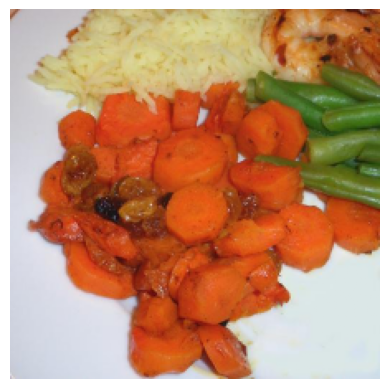

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Example prediction
for images, labels in validation_dataset.take(1):
    preds = model.predict(images)
    preds = (preds > 0.5).astype(int)
    print("True:", np.where(labels[0].numpy() == 1)[0])
    print("Predicted:", np.where(preds[0] == 1)[0])
    plt.imshow(images[0])
    plt.axis('off')
    plt.show()
    break